### Checking metadata and molecular data for matching IDs, merging data, exploring data, etc.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set options for better visualization
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [10]:
# import metadata
clinical_data = pd.read_excel("/Users/galebabu-ali/Documents/CPTAC-PDA/Data/Metadata/metadata_from_flagship_paper.xlsx", sheet_name='Clinical_data')
mol_pheno_data = pd.read_excel("/Users/galebabu-ali/Documents/CPTAC-PDA/Data/Metadata/metadata_from_flagship_paper.xlsx", sheet_name='Molecular_phenotype_data')
# merge datasets on 'case_id'
merged_metadata = pd.merge(clinical_data, mol_pheno_data, on='case_id')

# import metadata downloaded using cptac module
clinical_data_cptac = pd.read_csv('/Users/galebabu-ali/Documents/CPTAC-PDA/Data/Metadata/PDAC_clinical.csv')


In [11]:
# get dimensions of all datasets
print("Clinical Data Shape:", clinical_data.shape)
print("Molecular Phenotype Data Shape:", mol_pheno_data.shape)
print("Merged Metadata Shape:", merged_metadata.shape)
print("CPTAC Clinical Data Shape:", clinical_data_cptac.shape)

Clinical Data Shape: (140, 39)
Molecular Phenotype Data Shape: (140, 50)
Merged Metadata Shape: (140, 88)
CPTAC Clinical Data Shape: (140, 125)


In [11]:
# count case_ids have neoplastic_cellularity_histology_estimate > 0.15, without making a new dataframe
high_cellularity_count = merged_metadata[merged_metadata['neoplastic_cellularity_histology_estimate'] > 0.15]['case_id'].nunique()
print("Number of case_ids with neoplastic_cellularity_histology_estimate > 0.15:", high_cellularity_count)

Number of case_ids with neoplastic_cellularity_histology_estimate > 0.15: 108


In [12]:
# count case ids that have KRAS_VAF >= 0.075
kras_vaf_count = merged_metadata[merged_metadata['KRAS_VAF'] >= 0.075]['case_id'].nunique()
print("Number of case_ids with KRAS_VAF >= 0.075:", kras_vaf_count)

Number of case_ids with KRAS_VAF >= 0.075: 101


In [12]:
# from clinical_data_cptac, create dataframe with Patient_ID and Recurrence-free survival, days and Recurrence status (1, yes; 0, no) and Overall survival, days and Survival status (1, dead; 0, alive)
survival_data = clinical_data_cptac[['Patient_ID', 'Recurrence-free survival, days', 'Recurrence status (1, yes; 0, no)', 'Overall survival, days', 'Survival status (1, dead; 0, alive)']]
print( survival_data.head() )

# rename columns for easier access
survival_data = survival_data.rename(columns={
    'Patient_ID': 'case_id',
    'Recurrence-free survival, days': 'PFS_days',
    'Recurrence status (1, yes; 0, no)': 'PFS_event',
    'Overall survival, days': 'OS_days',
    'Survival status (1, dead; 0, alive)': 'OS_event'
})
print( survival_data.head() )

  Patient_ID  Recurrence-free survival, days  Recurrence status (1, yes; 0, no)  Overall survival, days  Survival status (1, dead; 0, alive)
0  C3L-00017                             NaN                                  0                   426.0                                  0.0
1  C3L-00102                           172.0                                  1                   249.0                                  1.0
2  C3L-00189                           424.0                                  1                  1036.0                                  1.0
3  C3L-00277                             NaN                                  0                   610.0                                  1.0
4  C3L-00401                           532.0                                  1                  1262.0                                  1.0
     case_id  PFS_days  PFS_event  OS_days  OS_event
0  C3L-00017       NaN          0    426.0       0.0
1  C3L-00102     172.0          1    249.0      

In [13]:
# append survival data to merged_metadata on 'case_id'
merged_metadata = pd.merge(merged_metadata, survival_data, on='case_id', how='left')
print("Merged Metadata with Survival Data Shape:", merged_metadata.shape)

Merged Metadata with Survival Data Shape: (140, 92)


In [14]:
# load file LinkedOmics_PDAC_survival.txt into new dataframe named linked_omics_survival
linked_omics_survival = pd.read_csv('../Data/LinkedOmics_Data/PDAC_survival.txt', sep='\t')
print( linked_omics_survival.head() )

     case_id  OS_days  OS_event  PFS_days  PFS_event
0  C3L-00017    426.0       0.0     426.0          0
1  C3L-00102    249.0       1.0     172.0          1
2  C3L-00277    610.0       1.0     730.0          0
3  C3L-00589   1752.0       0.0    1752.0          0
4  C3L-00598    422.0       1.0     348.0          1


In [15]:
# count overlap in case_ids between linked_omics_survival and survival_data dataframes without creating new variable
overlap_case_ids = set(linked_omics_survival['case_id']).intersection(set(survival_data['case_id']))
print("Number of overlapping case_ids between linked_omics_survival and survival_data:", len(overlap_case_ids))



Number of overlapping case_ids between linked_omics_survival and survival_data: 105


In [16]:
# count overlap in case_ids between linked_omics_survival and high cellularity count
overlap_high_cellularity_case_ids = set(linked_omics_survival['case_id']).intersection(set(merged_metadata[merged_metadata['neoplastic_cellularity_histology_estimate'] > 0.15]['case_id']))
print("Number of overlapping case_ids between linked_omics_survival and high cellularity cases:", len(overlap_high_cellularity_case_ids))

Number of overlapping case_ids between linked_omics_survival and high cellularity cases: 90


In [29]:
# load LinkedOmics transcriptomics and proteomics data
linked_omics_tx_tumor = pd.read_csv('../Data/LinkedOmics_data/mRNA_RSEM_UQ_log2_Tumor.cct', sep='\t')
linked_omics_tx_duct = pd.read_csv('../Data/LinkedOmics_data/mRNA_RSEM_UQ_log2_Duct.cct', sep='\t')
linked_omics_tx_normal = pd.read_csv('../Data/LinkedOmics_data/mRNA_RSEM_UQ_log2_Normal.cct', sep='\t')
linked_omics_prot_tumor = pd.read_csv('../Data/LinkedOmics_data/proteomics_gene_level_MD_abundance_tumor.cct', sep='\t')
linked_omics_prot_normal = pd.read_csv('../Data/LinkedOmics_data/proteomics_gene_level_MD_abundance_normal.cct', sep='\t')

In [56]:
# create new dataframe linked_omics_tx_samples as follows:
# take case_id (header row) from each linked_omics_tx dataframe and transpose it to a column named case_id
# create another column named sample_type with values 'tumor', 'duct', 'normal' respectively
linked_omics_tx_tumor_samples = pd.DataFrame({'case_id': linked_omics_tx_tumor.columns[1:], 'sample_type': 'tumor'})
linked_omics_tx_duct_samples = pd.DataFrame({'case_id': linked_omics_tx_duct.columns[1:], 'sample_type': 'duct'})
linked_omics_tx_normal_samples = pd.DataFrame({'case_id': linked_omics_tx_normal.columns[1:], 'sample_type': 'normal'})
linked_omics_tx_samples = pd.concat([linked_omics_tx_tumor_samples, linked_omics_tx_duct_samples, linked_omics_tx_normal_samples], ignore_index=True)
print( linked_omics_tx_samples.head() )
print( linked_omics_tx_samples.tail() )
print( linked_omics_tx_samples['sample_type'].value_counts() )
# save linked_omics_tx_samples to csv
linked_omics_tx_samples.to_csv('../Data/LinkedOmics_tx_sample_types.csv', index=False)

     case_id sample_type
0  C3L-03394       tumor
1  C3N-03428       tumor
2  C3L-02112       tumor
3  C3N-01719       tumor
4  C3N-03670       tumor
       case_id sample_type
163  C3N-03440      normal
164  C3N-02010      normal
165  C3L-04072      normal
166  C3N-03069      normal
167  C3L-02899      normal
sample_type
tumor     140
normal     21
duct        7
Name: count, dtype: int64


In [37]:
# count overlap in case ids between clinical_data (index) and linked_omics_tx_tumor (column header)
overlap_tx_tumor = set(clinical_data['case_id']).intersection(set(linked_omics_tx_tumor.columns[1:]))  # exclude first column which is gene names
print("Number of overlapping case_ids between clinical_data and linked_omics_tx_tumor:", len(overlap_tx_tumor))

# count overlap in case ids between clinical_data (index) and linked_omics_prot_tumor (column header)
overlap_prot_tumor = set(clinical_data['case_id']).intersection(set(linked_omics_prot_tumor.columns[1:]))  # exclude first column which is gene names
print("Number of overlapping case_ids between clinical_data and linked_omics_prot_tumor:", len(overlap_prot_tumor))

# count overlap in case ids between linked_omics_tx_tumor and linked_omics_prot_tumor
overlap_tx_prot_tumor = set(linked_omics_tx_tumor.columns[1:]).intersection(set(linked_omics_prot_tumor.columns[1:]))  # exclude first column which is gene names
print("Number of overlapping case_ids between linked_omics_tx_tumor and linked_omics_prot_tumor:", len(overlap_tx_prot_tumor))

# count overlap in case ids between survival_data (index) and linked_omics_tx_tumor (column header)
overlap_survival_tx_tumor = set(survival_data['case_id']).intersection(set(linked_omics_tx_tumor.columns[1:]))  # exclude first column which is gene names
print("Number of overlapping case_ids between survival_data and linked_omics_tx_tumor:", len(overlap_survival_tx_tumor))

# count overlap in case ids between survival_data (index) and linked_omics_prot_tumor (column header)
overlap_survival_prot_tumor = set(survival_data['case_id']).intersection(set(linked_omics_prot_tumor.columns[1:]))  # exclude first column which is gene names
print("Number of overlapping case_ids between survival_data and linked_omics_prot_tumor:", len(overlap_survival_prot_tumor))

# count overlap in case ids between linked_omics_survival (index) and linked_omics_tx_tumor (column header)
overlap_linkedomics_tx_tumor = set(linked_omics_survival['case_id']).intersection(set(linked_omics_tx_tumor.columns[1:]))  # exclude first column which is gene names
print("Number of overlapping case_ids between linked_omics_survival and linked_omics_tx_tumor:", len(overlap_linkedomics_tx_tumor))

Number of overlapping case_ids between clinical_data and linked_omics_tx_tumor: 140
Number of overlapping case_ids between clinical_data and linked_omics_prot_tumor: 140
Number of overlapping case_ids between linked_omics_tx_tumor and linked_omics_prot_tumor: 140
Number of overlapping case_ids between survival_data and linked_omics_tx_tumor: 140
Number of overlapping case_ids between survival_data and linked_omics_prot_tumor: 140
Number of overlapping case_ids between linked_omics_survival and linked_omics_tx_tumor: 105


In [17]:
# save survival_data to csv
survival_data.to_csv('../Data/PDAC_survival_data.csv', index=False)


In [18]:
# Load PurIST calls
purist_calls = pd.read_csv('../Results/PurIST_Classification_Results.csv')
# replace Unnamed: 0 with case_id
purist_calls = purist_calls.rename(columns={'Unnamed: 0': 'case_id'})
#print( purist_calls.head() )
# replace dot in case_id with hyphen
purist_calls['case_id'] = purist_calls['case_id'].str.replace('.', '-')
#print( purist_calls.head() )
# merge purist_calls with merged_metadata on case_id
merged_metadata2 = pd.merge(merged_metadata, purist_calls[['case_id', 'Subtype', 'Subtype_graded']], on='case_id', how='left')
# rename Subtype to PurIST_Subtype and Subtype_graded to PurIST_Subtype_graded
merged_metadata2 = merged_metadata2.rename(columns={'Subtype': 'PurIST_Subtype', 'Subtype_graded': 'PurIST_Subtype_graded'})
print("Merged Metadata with PurIST Calls Shape:", merged_metadata2.shape)
print(merged_metadata2.iloc[:,-5:].head())

Merged Metadata with PurIST Calls Shape: (140, 94)
   PFS_event  OS_days  OS_event PurIST_Subtype PurIST_Subtype_graded
0          1    249.0       1.0      classical      strong classical
1          1   1036.0       1.0     basal-like     strong basal-like
2          0    610.0       1.0      classical      strong classical
3          1   1262.0       1.0      classical      strong classical
4          1    594.0       0.0      classical      strong classical


In [31]:
# load Data/Metadata/Metadata_Report_CPTAC_PDA_2025_10_20-1.csv and append ROIVolume column to merged_metadata2
roi_report = pd.read_csv('../Data/Metadata/Metadata_Report_CPTAC_PDA_2025_10_20-1.csv')
# subset to StructureSetLabel==PANCREAS1 and select only case_id and ROIVolume columns
roi_report = roi_report[roi_report['StructureSetLabel'] == 'PANCREAS1']
roi_report = roi_report[['PatientID', 'ClinicalTrialTimePointID', 'ROIVolume']]
# rename PatientID to case_id
roi_report = roi_report.rename(columns={'PatientID': 'case_id'})
print( roi_report.shape )
# keep only Pre-Dose timepoint
roi_report = roi_report[roi_report['ClinicalTrialTimePointID'] == 'Pre-Dose']
# drop ClinicalTrialTimePointID column
roi_report = roi_report.drop(columns=['ClinicalTrialTimePointID'])
print( roi_report.shape )
# drop NAs in ROIVolume
roi_report = roi_report.dropna(subset=['ROIVolume'])
print( roi_report.shape )
# count unique case_ids in roi_report
print("Unique case_ids in roi_report:", roi_report['case_id'].nunique())
# average ROIVolume for duplicate case_ids
roi_report = roi_report.groupby('case_id', as_index=False).mean()
print( roi_report.shape )


(268, 3)
(250, 2)
(125, 2)
Unique case_ids in roi_report: 75
(75, 2)


In [33]:
# merge with merged_metadata2 on case_id
merged_metadata3 = pd.merge(merged_metadata2, roi_report, on='case_id', how='left')
print("Merged Metadata with ROIVolume Shape:", merged_metadata3.shape)
print(merged_metadata3.iloc[:,-5:].head())
print(merged_metadata3.shape)

Merged Metadata with ROIVolume Shape: (140, 95)
   OS_days  OS_event PurIST_Subtype PurIST_Subtype_graded  ROIVolume
0    249.0       1.0      classical      strong classical        NaN
1   1036.0       1.0     basal-like     strong basal-like        NaN
2    610.0       1.0      classical      strong classical        NaN
3   1262.0       1.0      classical      strong classical   7.290634
4    594.0       0.0      classical      strong classical        NaN
(140, 95)


In [34]:
# save final merged metadata to csv
merged_metadata3.to_csv('../Data/Metadata/metadata_merged_clinical_mol-phenotype_from_paper.csv', index=False)

In [123]:
pd.crosstab(index=pd.Series(merged_metadata2['PurIST_Subtype'], name='PurIST'), columns=pd.Series(merged_metadata2['Moffitt'], name='Moffitt'))

Moffitt,BASAL-LIKE,CLASSICAL
PurIST,,
basal-like,22,0
classical,32,71


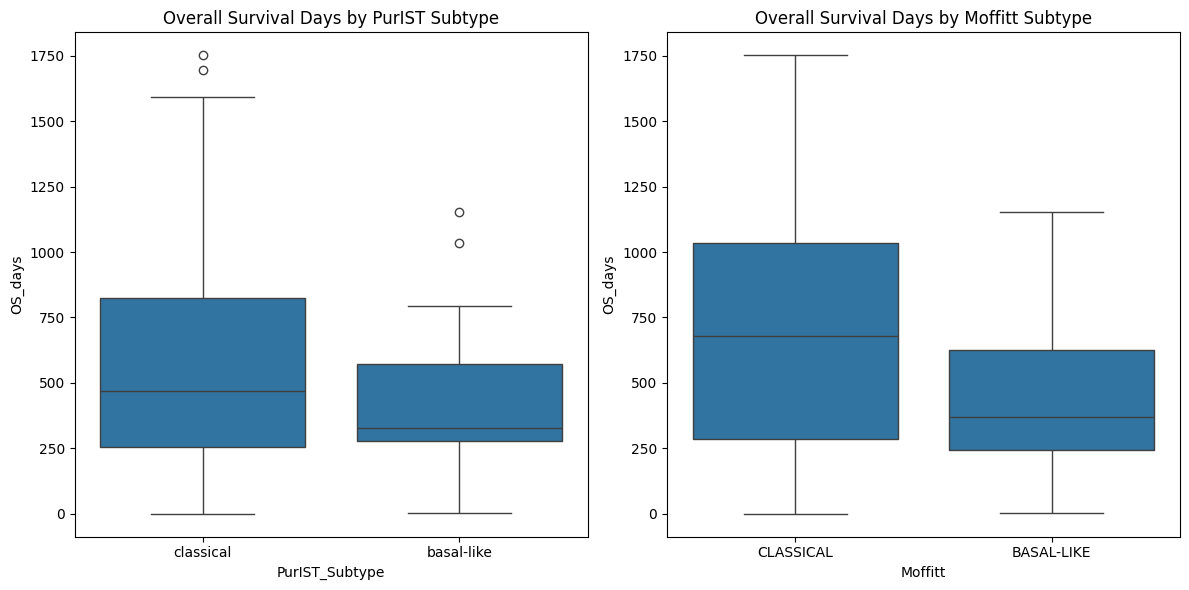

In [124]:
# plot two boxplots side by side: overall survival days (OS_days) for PurIST subtypes and Moffitt subtypes
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='PurIST_Subtype', y='OS_days', data=merged_metadata2)
plt.title('Overall Survival Days by PurIST Subtype')
plt.subplot(1, 2, 2)
sns.boxplot(x='Moffitt', y='OS_days', data=merged_metadata2)
plt.title('Overall Survival Days by Moffitt Subtype')
plt.tight_layout()
plt.show()

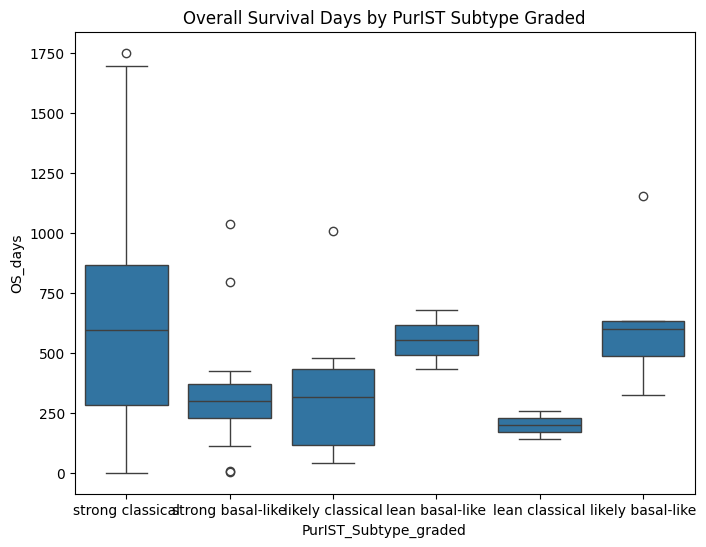

In [125]:
# boxplot of survival days (OS_days) for PurIST subtypes graded
plt.figure(figsize=(8, 6))
sns.boxplot(x='PurIST_Subtype_graded', y='OS_days', data=merged_metadata2)
plt.title('Overall Survival Days by PurIST Subtype Graded')
plt.show()

In [135]:
print(merged_metadata2['Moffitt'].value_counts(), "\n")
print(merged_metadata2['PurIST_Subtype'].value_counts(), "\n")
print(merged_metadata2['PurIST_Subtype_graded'].value_counts(), "\n")

Moffitt
CLASSICAL     71
BASAL-LIKE    54
Name: count, dtype: int64 

PurIST_Subtype
classical     118
basal-like     22
Name: count, dtype: int64 

PurIST_Subtype_graded
strong classical     106
strong basal-like     15
likely classical      10
likely basal-like      5
lean basal-like        2
lean classical         2
Name: count, dtype: int64 



In [120]:
# correlate neoplastic_cellularity_histology_estimate with KRAS_VAF using Spearman correlation
correlation = merged_metadata2[['neoplastic_cellularity_histology_estimate', 'KRAS_VAF']].corr(method='spearman')
print("Spearman correlation between neoplastic_cellularity_histology_estimate and KRAS_VAF:\n", correlation)

Spearman correlation between neoplastic_cellularity_histology_estimate and KRAS_VAF:
                                            neoplastic_cellularity_histology_estimate  KRAS_VAF
neoplastic_cellularity_histology_estimate                                   1.000000  0.420289
KRAS_VAF                                                                    0.420289  1.000000


In [43]:
# summary statistics of neoplastic_cellularity_histology_estimate and KRAS_VAF
print("Summary statistics for neoplastic_cellularity_histology_estimate:\n", merged_metadata['neoplastic_cellularity_histology_estimate'].describe())
print("Summary statistics for KRAS_VAF:\n", merged_metadata['KRAS_VAF'].describe())

Summary statistics for neoplastic_cellularity_histology_estimate:
 count    140.000000
mean       0.297300
std        0.174788
min        0.009901
25%        0.160000
50%        0.250616
75%        0.418750
max        0.750000
Name: neoplastic_cellularity_histology_estimate, dtype: float64
Summary statistics for KRAS_VAF:
 count    135.000000
mean       0.143232
std        0.098908
min        0.017483
25%        0.075508
50%        0.122302
75%        0.169648
max        0.478488
Name: KRAS_VAF, dtype: float64


In [47]:
# how many samples have neoplastic_cellularity_histology_estimate above first quartile (Q1)
q1_neoplastic_cellularity = merged_metadata['neoplastic_cellularity_histology_estimate'].quantile(0.25)
count_above_q1 = merged_metadata[merged_metadata['neoplastic_cellularity_histology_estimate'] >= q1_neoplastic_cellularity]['case_id'].nunique()
print("Number of case_ids with neoplastic_cellularity_histology_estimate above Q1 (", q1_neoplastic_cellularity, "):", count_above_q1)

Number of case_ids with neoplastic_cellularity_histology_estimate above Q1 ( 0.16 ): 107


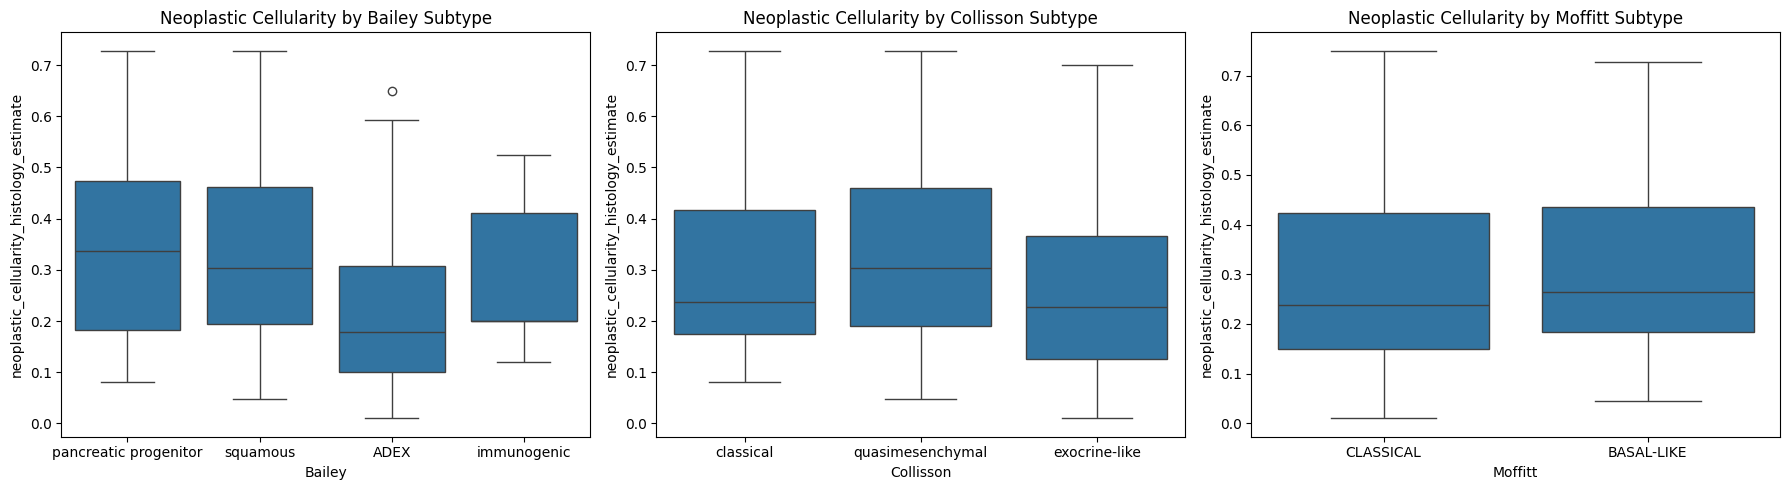

In [83]:
# three separate boxplots of neoplastic_cellularity_histology_estimate where x-axis are  Bailey, Collisson, Moffitt and y-axis is neoplastic_cellularity_histology_estimate
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='Bailey', y='neoplastic_cellularity_histology_estimate', data=merged_metadata)
plt.title('Neoplastic Cellularity by Bailey Subtype')
plt.subplot(1, 3, 2)
sns.boxplot(x='Collisson', y='neoplastic_cellularity_histology_estimate', data=merged_metadata)
plt.title('Neoplastic Cellularity by Collisson Subtype')
plt.subplot(1, 3, 3)
sns.boxplot(x='Moffitt', y='neoplastic_cellularity_histology_estimate', data=merged_metadata)
plt.title('Neoplastic Cellularity by Moffitt Subtype')
plt.tight_layout()
plt.show()

In [99]:
# load PDAC_transcriptomics_RAW_counts_renamed.tsv and drop gene_id and gene_type columns
tx_raw_counts = pd.read_csv('../Data/PDAC_transcriptomics_RAW_counts_renamed.tsv', sep='\t')
tx_raw_counts = tx_raw_counts.drop(columns=['gene_id', 'gene_type'])
print( tx_raw_counts.shape )

# subset tx_raw_counts to only include case_id present in linked_omics_tx_tumor; case_ids start from second column
tx_raw_counts_subset = tx_raw_counts[['gene_name'] + [col for col in tx_raw_counts.columns if col in linked_omics_tx_tumor.columns[1:]]]
print( tx_raw_counts_subset.shape )

# subset tx_raw_counts_subset to only include genes present in linked_omics_tx_tumor; gene names are in first column
tx_raw_counts_final = tx_raw_counts_subset[tx_raw_counts_subset['gene_name'].isin(linked_omics_tx_tumor['Unnamed: 0']) ]
print( tx_raw_counts_final.shape )

# in tx_raw_counts_final drop duplicates that have same gene_name but zero counts across all samples
sample_cols = tx_raw_counts_final.columns.difference(['gene_name'])
row_sums = tx_raw_counts_final[sample_cols].sum(axis=1)
is_duplicate = tx_raw_counts_final.duplicated(subset=['gene_name'], keep=False)

# Remove rows that are duplicates AND have zero total expression
tx_raw_counts_final = tx_raw_counts_final[~(is_duplicate & (row_sums == 0))]

# If duplicates still exist (e.g. multiple entries with expression), keep the one with highest total expression
tx_raw_counts_final = tx_raw_counts_final.sort_values(by=list(sample_cols), ascending=False).drop_duplicates('gene_name')
print("Final shape after dropping duplicates:", tx_raw_counts_final.shape )

# save tx_raw_counts_final to csv
tx_raw_counts_final.to_csv('../Data/PDAC_tx_RAW_counts_matched_linkedomics_tumor.csv', index=False)

# linked_omics_tx_tumor.shape (28057, 141)

(60660, 246)
(60660, 141)
(25563, 141)
Final shape after dropping duplicates: (25441, 141)


In [70]:
# head genes that are missing in tx_raw_counts_final but present in linked_omics_tx_tumor
missing_genes = set(linked_omics_tx_tumor['Unnamed: 0']).difference(set(tx_raw_counts_final['gene_name']))
print("Genes present in linked_omics_tx_tumor but missing in tx_raw_counts_final:\n", list(missing_genes)[:10])  # print first 10 missing genes

Genes present in linked_omics_tx_tumor but missing in tx_raw_counts_final:
 ['C1orf123', 'LOC401320', 'LOC399716', 'C15orf38-AP3S2', 'SNORD154', 'LOC101929679', 'LOC101927272', 'SNORD168', 'LOC100996251', 'FAM231AP']


In [63]:
linked_omics_tx_tumor.iloc[:5,:5]

,Unnamed: 0,C3L-03394,C3N-03428,C3L-02112,C3N-01719
0,A1BG,6.692021,6.355394,7.369336,5.837855
1,A1BG-AS1,7.525181,6.976172,6.951589,6.389844
2,A1CF,10.042247,6.944645,8.976580,7.296482
3,A2M,15.906459,14.685723,15.515414,15.727089
4,A2M-AS1,9.210500,9.168838,8.150627,8.728630


In [71]:
tx_raw_counts_final.iloc[:5,:5]

,gene_name,C3N-03884,C3L-04027,C3N-04283,C3L-04475
0,TSPAN6,338,236,1966,1338
1,TNMD,9,5,15,16
2,DPM1,626,1248,2142,1247
3,SCYL3,375,1374,1327,1254
4,C1orf112,215,650,640,448


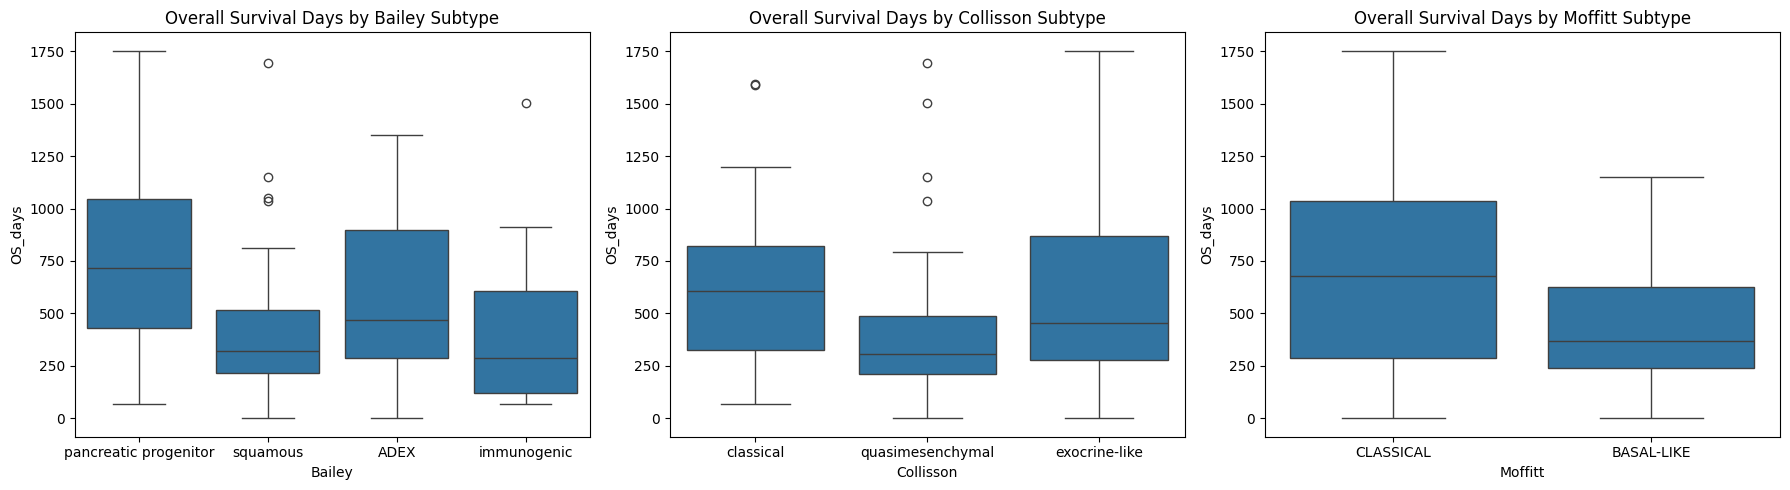

In [87]:
# three separate boxplots of Overall survival, days where x-axis are  Bailey, Collisson, Moffitt and y-axis is Overall survival, days
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(x='Bailey', y='OS_days', data=merged_metadata)
plt.title('Overall Survival Days by Bailey Subtype')
plt.subplot(1, 3, 2)
sns.boxplot(x='Collisson', y='OS_days', data=merged_metadata)
plt.title('Overall Survival Days by Collisson Subtype')
plt.subplot(1, 3, 3)
sns.boxplot(x='Moffitt', y='OS_days', data=merged_metadata)
plt.title('Overall Survival Days by Moffitt Subtype')
plt.tight_layout()
plt.show()

In [103]:
# how many genes in linked_omics_tx_tumor have zero expression across all samples
sample_cols_lo_tt = linked_omics_tx_tumor.columns.difference(['Unnamed: 0'])
row_sums_lo_tt = linked_omics_tx_tumor[sample_cols_lo_tt].sum(axis=1)
zero_expression_genes_lo_tt = linked_omics_tx_tumor[row_sums_lo_tt == 0]
print("Number of genes in linked_omics_tx_tumor with zero expression across all samples:", zero_expression_genes_lo_tt.shape[0])

Number of genes in linked_omics_tx_tumor with zero expression across all samples: 2091
